<a href="https://colab.research.google.com/github/davidrtorres/Deep_Learning/blob/main/Image_Segmentation_with_Multi_Labeled_Images_Using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Segmentation with Multi-Labeled Images Using ML

In this notebook I am working with Image Segmentation.  However, I am no longer just using a single image and mask to train a model.  In this notebook I’ll be using multiple images (10) and corresponding masks (10) to train a model.  The pixel values will be the inputs for the model and the mask/label values are what we'll be trying to predict.  The process will consist of the following:<br>
1. Read in the images and masks
2. Add image pixel values and preprocessing of images to a dataframe.
3. Extract features from images using Gabor and Edge filters.  Append the resulting responses to a data frame as features.  
4. Add mask values to a separate dataframe
5. Join the image and mask dataframes.
6. Split the data into training and test sets.
7. Build Random Forest model and train model with train set.
8. Make a prediction using model.   
<br>
<br>

I followed the Youtube video series for image segmentation by Digital Sreeni (https://www.youtube.com/watch?v=VCrLaEHShDo&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=83).



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import os
import glob
from skimage.filters import roberts,sobel, scharr, prewitt
from sklearn.model_selection import train_test_split
import pickle
import tifffile

from google.colab.patches import cv2_imshow

### Process for Creating Dataframe and Extracting Features
I read in several images.  By using a for loop I am able to read in one image at a time and apply the same process to each image.  I converted the images to a gray scale if they weren't already.  I created a temporary dataframe in the for loop and added the pixel values as one of the columns called 'Pixel_Value' to the dataframe.  The values needed to be reshaped to 1D so they could be added as features. 

Next, I extracted features using Gabor and other filters (Edge, etc.).  I applied these filters to the images and got responses.  These responses were added to the dataframe as features.<br>
I created a dataframe outside the for loop called image_dataset where I appended all of the above information.<br>

I applied a similar but shorter process to the mask images and created a dataframe called mask_images which I will discuss below.

In [2]:
image_dataset = pd.DataFrame()


img_path = '/content/drive/MyDrive/datasets/Train_images/' #*.tif

for image in os.listdir(img_path):
  print(image)

  df = pd.DataFrame()

  input_img = cv2.imread(img_path + image)
  if input_img.ndim== 3 and input_img.shape[-1] ==3:
    img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) #then convert images to gray 
  elif input_img.ndim== 2: 
    img = input_img #then don't have to do any processing
  else:
    raise Exception("Module only works with grayscale and RBG images") 

  pixel_values = img.reshape(-1) #reshape image to single column
  df['Pixel_Value'] = pixel_values
  df['Image_Name'] = image  

  #generate Gabor feature
  num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
  kernels = []  #Create empty list to hold all kernels that we will generate in a loop
  for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with values of 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                            
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
  #                print(gabor_label)
                  #kernal size
                ksize=9
                  #generate a Gabor kernal with each parameter 
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                  #apply kernal to image/filter the image and add values to a new column
                  #when you get kernal apply it to image2
                  #the filtered image is 2D 
                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                  #reshape filtered image/fimg to 1D
                filtered_img = fimg.reshape(-1)
                  #add new column to dataframe
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
    
    #Generate other features and add to dataframe
    #canny edge. Edge detection filters.  Get a canny edge filter
    edges = cv2.Canny(img, 100,200) #minimum and max value
    edges1 = edges.reshape(-1)
    df['Canny_Edge'] = edges1

    edge_roberts = roberts(img) #minimum and max value
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1

    edge_sobel = sobel(img) #minimum and max value
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1

    edge_scharr = scharr(img) #minimum and max value
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1 
 

Sandstone_Versa0400.tif
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0

In [3]:
df.head()

,Pixel_Value,Image_Name,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,...,Gabor23,Gabor24,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32
0,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['Image_Name'].value_counts()

Sandstone_Versa0000.tif    1019904
Name: Image_Name, dtype: int64

In [5]:
df['Pixel_Value'].value_counts()

0      267036
122     15145
123     15037
124     14893
120     14881
        ...  
202        79
208        79
203        77
213        68
214        66
Name: Pixel_Value, Length: 256, dtype: int64

In [6]:
image_dataset = image_dataset.append(df)

In [7]:
image_dataset.shape

(1019904, 38)

### Mask Dataset
The mask dataset will consist of 4 classes: 29, 76, 150, 226.  I created a for loop for the process.  I read in the mask/label images. I created a temporary dataframe in the loop for the label values.  The values were converted to gray if they were not gray already and reshaped them to 1D.  THe label values were appended to the dataframe mask_dataset.

In [8]:
mask_dataset = pd.DataFrame()

mask_path = '/content/drive/MyDrive/datasets/Train_masks/' #*.tif

for mask in os.listdir(mask_path):
  print(mask)

  df2 = pd.DataFrame()
  input_mask = cv2.imread(mask_path + mask)

  if input_mask.ndim == 3 and input_mask.shape[-1] == 3:
    label = cv2.cvtColor(input_mask, cv2.COLOR_BGR2GRAY)
  elif input_mask.ndim == 2: 
    label = input_mask
  else:
    raise Exception("Module only works with grayscale and RBG images") 

#add pixel values to Dataframe 
label_values = label.reshape(-1)
df2['Label_Values'] = label_values
df2['Mask_Name'] = mask   

mask_dataset = mask_dataset.append(df2)

Sandstone_Versa0150.tif
Sandstone_Versa0050.tif
Sandstone_Versa0350.tif
Sandstone_Versa0000_mask.tif
Sandstone_Versa0200.tif
Sandstone_Versa0300.tif
Sandstone_Versa0100.tif
Sandstone_Versa0400.tif
Sandstone_Versa0250.tif


In [9]:
mask_dataset.head()

,Label_Values,Mask_Name
0,29,Sandstone_Versa0250.tif
1,29,Sandstone_Versa0250.tif
2,29,Sandstone_Versa0250.tif
3,29,Sandstone_Versa0250.tif
4,29,Sandstone_Versa0250.tif


In [10]:
mask_dataset.shape

(1019904, 2)

In [11]:
mask_dataset['Label_Values'].value_counts()

29     496441
76     462352
150     47913
226     13198
Name: Label_Values, dtype: int64

In [12]:
mask_dataset['Mask_Name'].value_counts()

Sandstone_Versa0250.tif    1019904
Name: Mask_Name, dtype: int64

In [13]:
mask_dataset[mask_dataset['Label_Values'] == 226]

,Label_Values,Mask_Name
106126,226,Sandstone_Versa0250.tif
106127,226,Sandstone_Versa0250.tif
106128,226,Sandstone_Versa0250.tif
106129,226,Sandstone_Versa0250.tif
107122,226,Sandstone_Versa0250.tif
...,...,...
891158,226,Sandstone_Versa0250.tif
891159,226,Sandstone_Versa0250.tif
892152,226,Sandstone_Versa0250.tif
892153,226,Sandstone_Versa0250.tif


Concatenate the image_dataset and mask_dataset into one dataset called dataset.

In [14]:
dataset = pd.concat([image_dataset, mask_dataset], axis=1)

In [15]:
dataset.head(10)

,Pixel_Value,Image_Name,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,...,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32,Label_Values,Mask_Name
0,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
1,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
2,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
3,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
4,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
5,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
6,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
7,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
8,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif
9,0,Sandstone_Versa0000.tif,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,29,Sandstone_Versa0250.tif


In [16]:
dataset.shape

(1019904, 40)

In [17]:
dataset2 =dataset[dataset.Pixel_Value != 0]


Above shows that there are 267036 rows with a pixel value of 0.  I dropped the pixels with a value of 0.  A pixel value of 0 has no meaning we can use for training purposes.   

In [18]:
dataset2['Pixel_Value'].value_counts()

122    15145
123    15037
124    14893
120    14881
121    14797
       ...  
202       79
208       79
203       77
213       68
214       66
Name: Pixel_Value, Length: 255, dtype: int64

In [19]:
dataset2['Label_Values'].value_counts()

76     459029
29     233129
150     47608
226     13102
Name: Label_Values, dtype: int64

In [20]:
dataset2.shape

(752868, 40)

In [21]:
dataset2[dataset2['Label_Values'] == 150]

,Pixel_Value,Image_Name,Gabor1,Gabor2,Gabor3,Gabor4,Gabor5,Gabor6,Gabor7,Gabor8,...,Gabor25,Gabor26,Gabor27,Gabor28,Gabor29,Gabor30,Gabor31,Gabor32,Label_Values,Mask_Name
89160,93,Sandstone_Versa0000.tif,0,0,255,202,51,25,0,0,...,0,0,255,255,37,16,74,42,150,Sandstone_Versa0250.tif
89161,104,Sandstone_Versa0000.tif,0,0,255,244,99,50,16,4,...,0,0,255,255,36,19,68,40,150,Sandstone_Versa0250.tif
89162,138,Sandstone_Versa0000.tif,0,0,255,255,255,149,124,73,...,0,0,255,255,39,23,31,12,150,Sandstone_Versa0250.tif
89163,157,Sandstone_Versa0000.tif,0,0,255,255,255,186,151,95,...,0,0,255,255,29,10,72,46,150,Sandstone_Versa0250.tif
89164,146,Sandstone_Versa0000.tif,0,0,255,255,250,134,107,52,...,0,0,255,255,57,35,91,61,150,Sandstone_Versa0250.tif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957631,44,Sandstone_Versa0000.tif,0,0,124,91,40,33,18,17,...,0,0,255,255,12,5,46,28,150,Sandstone_Versa0250.tif
957632,36,Sandstone_Versa0000.tif,0,0,141,88,33,21,3,2,...,0,0,255,255,30,20,0,0,150,Sandstone_Versa0250.tif
957633,36,Sandstone_Versa0000.tif,0,0,205,114,78,42,40,21,...,0,0,255,255,0,0,24,19,150,Sandstone_Versa0250.tif
957634,40,Sandstone_Versa0000.tif,0,0,227,121,86,44,42,22,...,0,0,255,255,28,21,45,37,150,Sandstone_Versa0250.tif


### Split Data into Train and Test Sets
The label values are what the model is going to predict with similar unknown images. 

In [22]:
X = dataset2.drop(['Image_Name', 'Mask_Name','Label_Values'], axis=1) #
y = dataset2['Label_Values'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_train.shape)

(602294, 37)
(602294,)
(150574, 37)
(602294,)


### Create the Model 
I created a Random Forest Classification model.  With the fit() method I trained the model on the training data.  I am also checking the accuracy or performance of the model in making a prediction on the X_test values.  In checking the accuracy I am comparing the X_test values to the y_test because y_test contains the true values.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [26]:
#create an instance of model
model1 = RandomForestClassifier(n_estimators=10,random_state=42)
#fit model to training dataset
model1.fit(X_train, y_train)
#need to validate model. Is it doing a good job?
#make a prediction
prediction = model1.predict(X_test)
#how good was prediciton? Check accuracy of test dataset 
print('Accuracy: ',metrics.accuracy_score(y_test, prediction))

Accuracy:  0.7806460610729608


### AUC-ROC Curve
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems.  The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
I am working with four classes.  The middle line is for random guesses so if I randomly guess which class a pixel belongs to there is a 25% chance it belongs to each of the categories.  The further the lines for each class are from the chance line the better the model is performing. We want the class lines to be as close to the upper left hand corner as possible which would indicate the model is performing well.  

In [27]:
from yellowbrick.classifier import ROCAUC

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


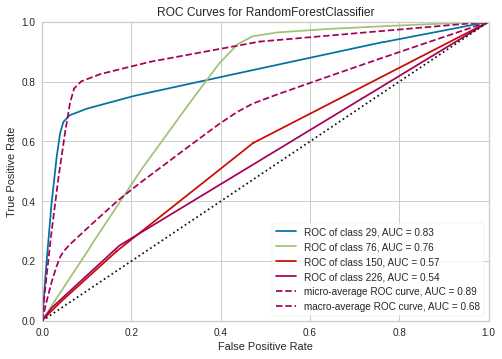

In [28]:
roc_auc = ROCAUC(model1)
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()

### Save the Model for Future Use
I am saving the model in a folder called sandstone_model_multi_image.

In [29]:
import pickle

In [30]:
model_name = '/content/drive/MyDrive/datasets/sandstone_model_multi_image'
pickle.dump(model1, open(model_name,'wb'))


### Make a Prediction

In [31]:
 def feature_extraction(img):
  df_2 = pd.DataFrame()
  #input image is a 2D, need to reshape to 1D 
  img2 = img.reshape(-1)
  #Save original image pixels into a data frame as feature #1.
  df_2['Original Image'] = img2
  num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
  kernels = []  #Create empty list to hold all kernels that we will generate in a loop
  for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with values of 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                           
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                # print(gabor_label)
                #kernal size
                ksize=9
                #generate a Gabor kernal with each parameter 
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #apply kernal to image/filter the image and add values to a new column
                #when you get kernal apply it to image2
                #the filtered image is 2D 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                #reshape filtered image/fimg to 1D
                filtered_img = fimg.reshape(-1)
                #add new column to dataframe
                df_2[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label

   #canny edge. Edge detection filter.  Get a canny edge filter
  edges = cv2.Canny(img, 100,200) #minimum and max value
  edges1 = edges.reshape(-1)
  df_2['Canny_Edge'] = edges1

  edge_roberts = roberts(img) #minimum and max value
  edge_roberts1 = edge_roberts.reshape(-1)
  df_2['Roberts'] = edge_roberts1

  edge_sobel = sobel(img) #minimum and max value
  edge_sobel1 = edge_sobel.reshape(-1)
  df_2['Sobel'] = edge_sobel1

  edge_scharr = scharr(img) #minimum and max value
  edge_scharr1 = edge_scharr.reshape(-1)
  df_2['Scharr'] = edge_scharr1 

  return df_2    

In [32]:
#load saved model 
file_name = '/content/drive/MyDrive/datasets/sandstone_model_multi_image'
load_model = pickle.load(open(file_name,'rb'))

This code will segment the new images with the saved model.

In [33]:
path = '/content/drive/MyDrive/datasets/Test_images/'
for image in os.listdir(path):
  print(image) 
  img1 = cv2.imread(path + image)
  img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  X = feature_extraction(img)
  result = load_model.predict(X)
  segmented = result.reshape((img.shape))
  #segmented = segmented.astype(np.int8)
  tifffile.imwrite('/content/drive/MyDrive/datasets/Segmented_images/'+ image, segmented)

sandstone_0015.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Pixel_Value

  warnings.warn(message, FutureWarning)


sandstone_0075.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Pixel_Value

  warnings.warn(message, FutureWarning)


sandstone_0120.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Pixel_Value

  warnings.warn(message, FutureWarning)


sandstone_0180.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Pixel_Value

  warnings.warn(message, FutureWarning)


sandstone_0270.tiff
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 :

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Original Image
Feature names seen at fit time, yet now missing:
- Pixel_Value

  warnings.warn(message, FutureWarning)


I'm going to compare the results.  Below are images that are titled 'Prior Segmented Image' and 'Segmented Image'.  The Segmented Image is the image that was segmented with the saved model.  This model didn't do a very good job of segmenting the images in the folder Test_images.  That's probably to be expected because the accuracy of the model was only 78%.      

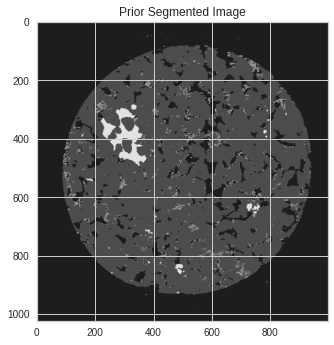

In [36]:
path='/content/drive/MyDrive/datasets/Segmented/sandstone_0015.tiff'
img = cv2.imread(path)
plt.title('Prior Segmented Image')
plt.imshow(img, cmap = 'jet')

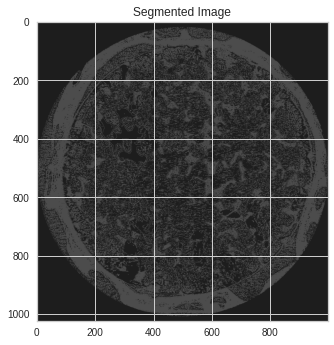

In [37]:
path='/content/drive/MyDrive/datasets/Segmented_images/sandstone_0015.tiff'
img = cv2.imread(path)
plt.title('Segmented Image')
plt.imshow(img, cmap = 'jet')

### Findings
The model's performance was not very good with an accuaracy of 78%.  I tried to increase the number of n_estimators to 300 but that only increased the accuracy to 80%.  The model's performance did increase to 85% when the pixels with a value of 0 weren't deleted.  I need to work on parameter optimization to improve the accuracy score, i.e. n_jobs.<br>
The real test was when I compared how a previous model had segmented image sandstone_0015.tiff to the current model.  The prior model did a good job of segmenting the image as shown above.  However, when applying the saved model to the same image for segmentation it didn't do a very good job at all.  It's hard to tell what was segmented. 
